# VAE and VSC for Cell Images

In [18]:
import torch
from torch import cuda
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils import data
from torchvision.utils import save_image
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_dir = '../../../Data/'
results_dir = '../../../results/'
batch_size = 128

torch.manual_seed(22)
device = torch.device("cuda" if cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

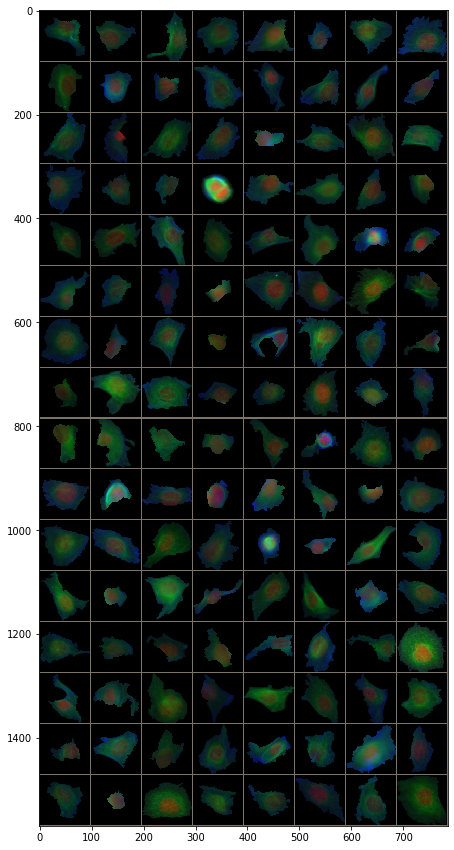

In [19]:
inputs, _ = next(iter(val_data))

out = torchvision.utils.make_grid(inputs)

imshow(out)
plt.show()

## VAE - Existing Work
First the VAE that was already developed was migrated from Tensorflow to Pytorch
before starting to work on the VSC

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        channels = 'placeholder'
        # Encoder
        self.encoder_conv1 = self.getConvolutionLayer(3, 128)
        self.encoder_conv2 = self.getConvolutionLayer(128, 64)
        self.encoder_conv3 = self.getConvolutionLayer(64, 32)
        
        self.flatten = nn.Flatten()

        self.encoder_fc1 = nn.Linear(4608, self.latent_dim)
        self.encoder_fc2 = nn.Linear(4608, self.latent_dim)
        
        # Decoder
        self.decoder_fc1 = nn.Sequential(
            nn.Linear(self.latent_dim, 4608),
            nn.ReLU()
        )
        # Reshape to 32x12x12
        self.decoder_upsampler1 = nn.Upsample(scale_factor=(2,2) ,mode='nearest')
        
        self.decoder_deconv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=(2,2) ,mode='nearest')
        )
        # 48x48x64
        self.decoder_deconv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=(2,2) ,mode='nearest')
        )

        self.decoder_conv1 = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=3, stride=1, padding=1)
        # 96x96x128
        

    def getConvolutionLayer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )


    def encode(self, x):
        x = self.encoder_conv1(x)
        x = self.encoder_conv2(x)
        x = self.encoder_conv3(x)
        
        x = self.flatten(x)
        mu = self.encoder_fc1(x)
        sigma = self.encoder_fc2(x)

        return mu, sigma

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        # Keeps shape, samples from normal dist with mean 0 and variance 1
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = self.decoder_fc1(z)
        z = self.decoder_upsampler1(z.view(-1, 32, 12, 12))
        z = self.decoder_deconv1(z)
        z = self.decoder_deconv2(z)
        recon = self.decoder_conv1(z)        
        return recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    # BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    mse = F.mse_loss(recon_x, x, reduction='mean')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return mse + kld

In [5]:
def split_data(data_dir, n_split=0.2, batch_size=256):
    
    pin_memory = cuda.is_available()
    workers = 0 if cuda.is_available() else 4
    
    # Create training and validation datasets
    image_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]))
    # Create training and validation dataloaders
    total = len(image_dataset)
    n_test = int(total * n_split)
    n_train = total - n_test 
    train_set, test_set = data.random_split(image_dataset, (n_train, n_test))

    n_val = int(len(train_set) * n_split)
    n_train = len(train_set) - n_val
    train_set, val_set = data.random_split(train_set, (n_train, n_val))  
    
    print('Train split: ', len(train_set))
    print('Val split: ', len(val_set))
    print('Test split: ', len(test_set))
    
    train_loader = data.DataLoader(
      train_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    val_loader = data.DataLoader(
      val_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    test_loader = data.DataLoader(
      test_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    return train_loader, val_loader, test_loader

In [6]:
def train(epoch, train_loader):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [7]:
def test(epoch, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 3, 96, 96)[:n]])
                save_image(comparison.cpu(),
                         results_dir + 'reconstruction_' + str(epoch) + '.tif', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:
model = VAE(256).to(device)
model

VAE(
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten()
  (encoder_fc1): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_fc2): Linear(in_features=4608, out_features=256, bias=True)
  (decoder_fc1): Sequential(
    (0): Linear(in_features=256, out_features=4608, bias=True)
    (1): ReLU()
  )
  (decoder_upsampler1): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
  (decoder_deco

In [9]:
train_data, val_data, test_data = split_data(data_dir=data_dir, batch_size=batch_size)

Train split:  26634
Val split:  6658
Test split:  8322


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(1, 50 + 1):
        train(epoch, train_data)
        test(epoch, val_data)
        with torch.no_grad():
            sample = torch.randn(64, 256).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 3, 96, 96),
                       results_dir + 'sample_' + str(epoch) + '.tif')

In [ ]:
vae.eval()
images, _ = next(iter(loader))
images = images.to(device)
images[0].shape

In [ ]:
print('*** Encoder ***')
mu, logvar = vae.encode(images)
print('*** Decoder ***')
z = vae.reparameterize(mu, logvar)
recon = vae.decode(z)